# Credit Card Fraud Detection Dataset

## Dataset Overview

**Source:** Real European credit card transactions from 2013, anonymized and transformed with PCA.

**Size:** 284,807 transactions, only 492 labeled as fraud.

## Features Description

- **Time:** Seconds since the first transaction
- **Amount:** Transaction amount
- **V1 to V28:** Transformed PCA components
- **Class:** Target variable (0 = genuine, 1 = fraud)

## Key Characteristics

- **Highly imbalanced dataset:** Only 0.172% of transactions are fraudulent
- **Anonymized features:** Original features were transformed using PCA for privacy
- **Time series data:** Transactions are ordered by time

In [2]:
!pip install imbalanced-learn lightgbm


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for Decomposition & Data Operations
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# for Outliers and Clusters Detection
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor

# for Model training
import lightgbm as lgb
from scipy.stats import f_oneway
import gc
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)

# for Saving 
import joblib
import json

In [4]:
# Overview of Data 
df = pd.read_csv("../creditcard.csv")
print(df.head())
print("--------------------------------")
print(df.shape)
print("--------------------------------")
print(df.dtypes)

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [5]:
# Preprocessing Data
print(f'Null Values: {df.isna().sum()}')
print(f'Duplicate Values: {df.duplicated().sum()}')
df = df.drop_duplicates()
print("Final Data Shape: ", df.shape)

Null Values: Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
Duplicate Values: 1081
Final Data Shape:  (283726, 31)


In [6]:
fraud = df[df['Class']==1]
non_fraud = df[df['Class']==0]

fraud.shape, non_fraud.shape

((473, 31), (283253, 31))

In [7]:
df['Class'].value_counts()

Class
0    283253
1       473
Name: count, dtype: int64

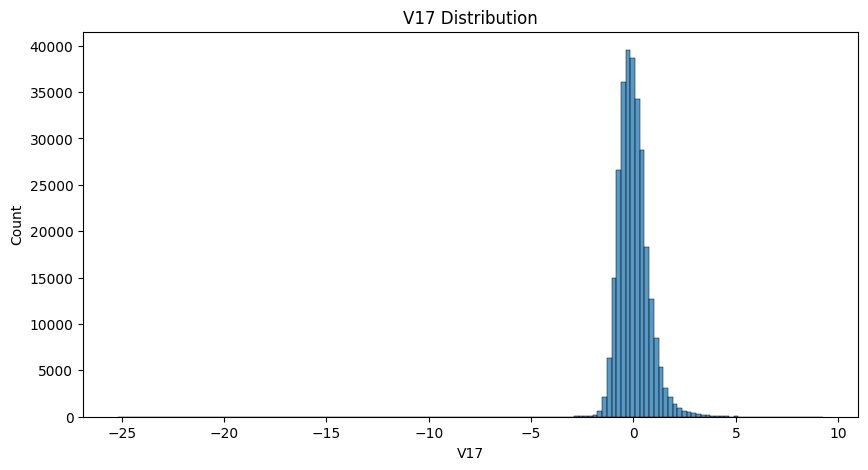

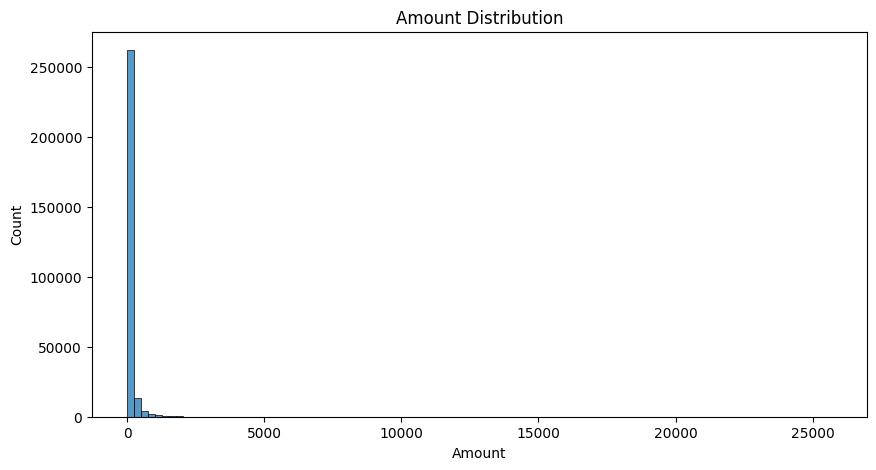

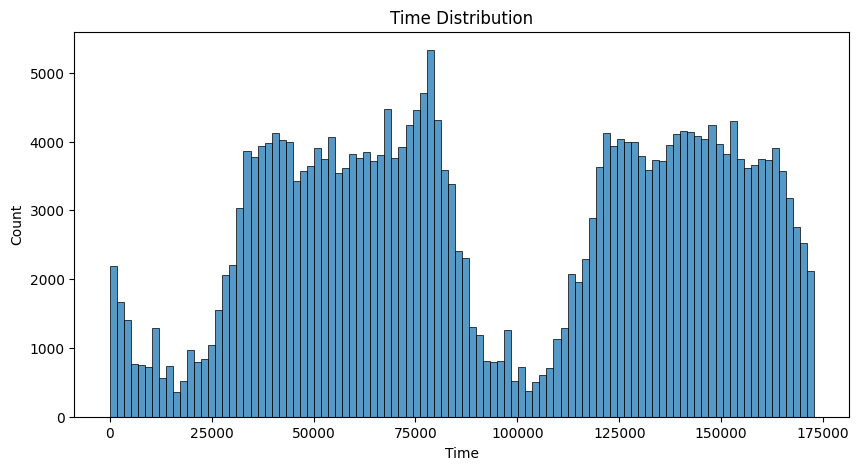

In [8]:
# Histograms of Feature rows; V17, Amount, Time
plt.figure(figsize=(10, 5))
sns.histplot(df['V17'], bins=150)
plt.title('V17 Distribution')
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df['Amount'], bins=100)
plt.title('Amount Distribution')
plt.show()
plt.figure(figsize=(10, 5))
sns.histplot(df['Time'], bins=100)
plt.title('Time Distribution')
plt.show()

Text(0.5, 1.0, 'Density of V17 by Class')

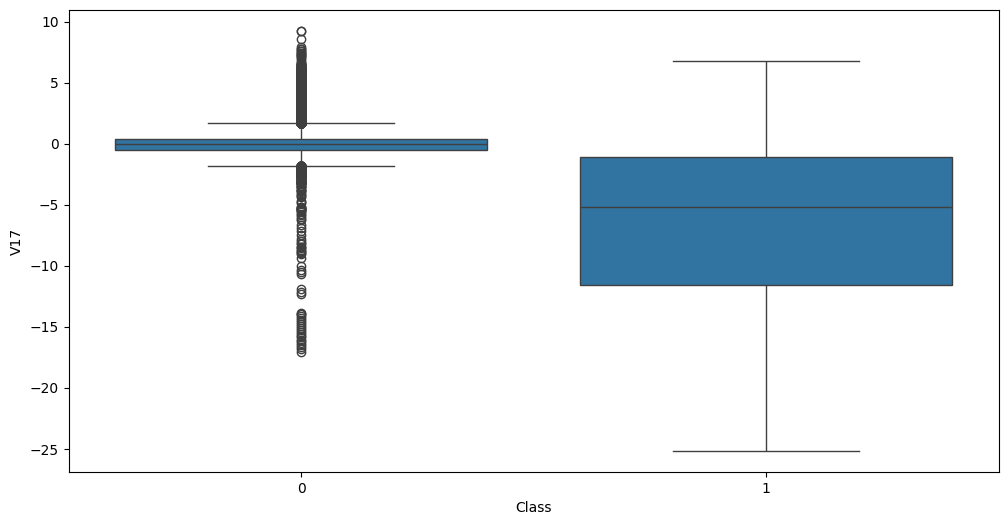

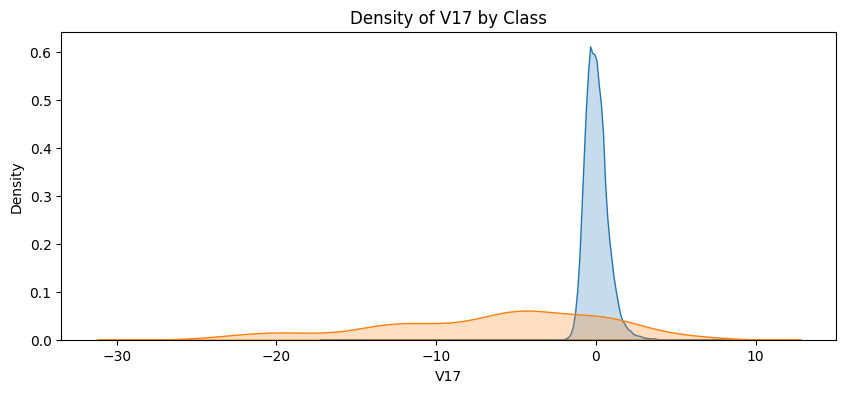

In [9]:
# Box plot of V17 with Class
plt.figure(figsize=(12,6))
sns.boxplot(x='Class', y='V17', data=df)

# KDE plot of V17 with Class (density based)
plt.figure(figsize=(10,4))
sns.kdeplot(non_fraud['V17'], label='Non-Fraud', fill=True)
sns.kdeplot(fraud['V17'], label='Fraud', fill=True)
plt.title("Density of V17 by Class")


## To understand the underlying distributions of selected features, I began with histograms of V17, Amount, and Time.

**V17**: Exhibited a sharp peak centered near 0, but with noticeable left skewness and long tails. Given its strong correlation with the Class label during EDA, this pattern hinted at possible anomaly behavior that justified deeper analysis later.

**Amount**: had a classic right-skewed distribution, as expected in financial datasets where smaller transactions dominate. The long tail on the right highlighted the presence of high-value outliers, which could be either legitimate bulk purchases or fraudulent spikes.

**Time**: showed a uniform spread across the 48-hour window, with no clear periodic pattern or daily cycle. This made it unlikely that time alone would serve as a useful discriminative feature, but potentially helpful when engineered into segments or hours.

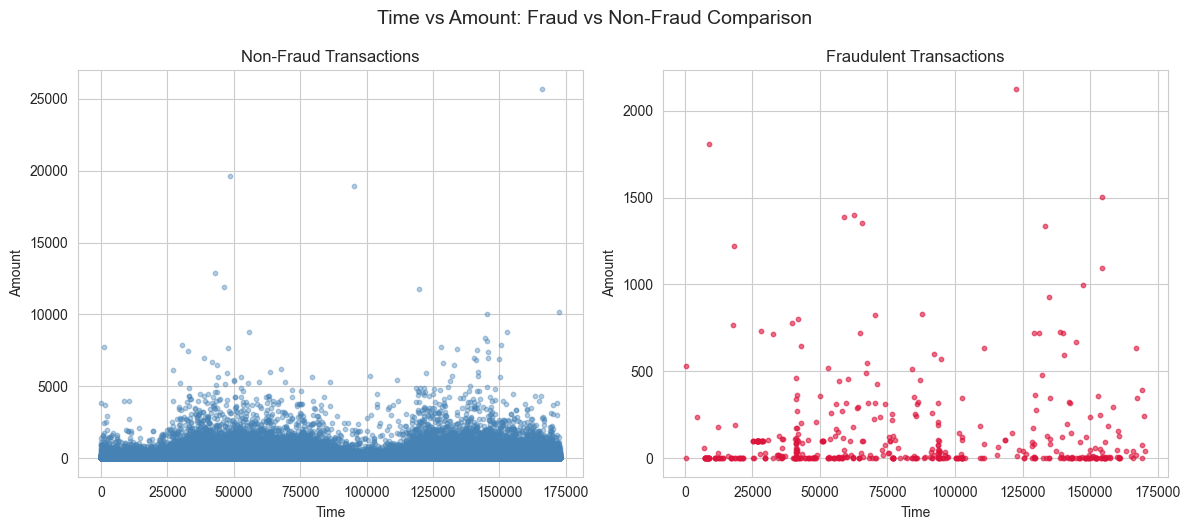

In [10]:
# Set the figure size and style
plt.figure(figsize=(12, 5))
sns.set_style('whitegrid')

# --- Scatter plot for Non-Fraud ---
plt.subplot(1, 2, 1)
plt.scatter(non_fraud['Time'], non_fraud['Amount'], alpha=0.4, s=10, c='steelblue')
plt.title('Non-Fraud Transactions')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.tight_layout()

# --- Scatter plot for Fraud ---
plt.subplot(1, 2, 2)
plt.scatter(fraud['Time'], fraud['Amount'], alpha=0.6, s=10, c='crimson')
plt.title('Fraudulent Transactions')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.tight_layout()

plt.suptitle('Time vs Amount: Fraud vs Non-Fraud Comparison', fontsize=14, y=1.05)
plt.show()

Class     1.000000
V11       0.149067
V4        0.129326
V2        0.084624
V19       0.033631
V8        0.033068
V21       0.026357
V27       0.021892
V20       0.021486
V28       0.009682
Amount    0.005777
V22       0.004887
V26       0.004265
V25       0.003202
V15      -0.003300
V13      -0.003897
V23      -0.006333
V24      -0.007210
Time     -0.012359
V6       -0.043915
V5       -0.087812
V9       -0.094021
V1       -0.094486
V18      -0.105340
V7       -0.172347
V3       -0.182322
V16      -0.187186
V10      -0.206971
V12      -0.250711
V14      -0.293375
V17      -0.313498
Name: Class, dtype: float64


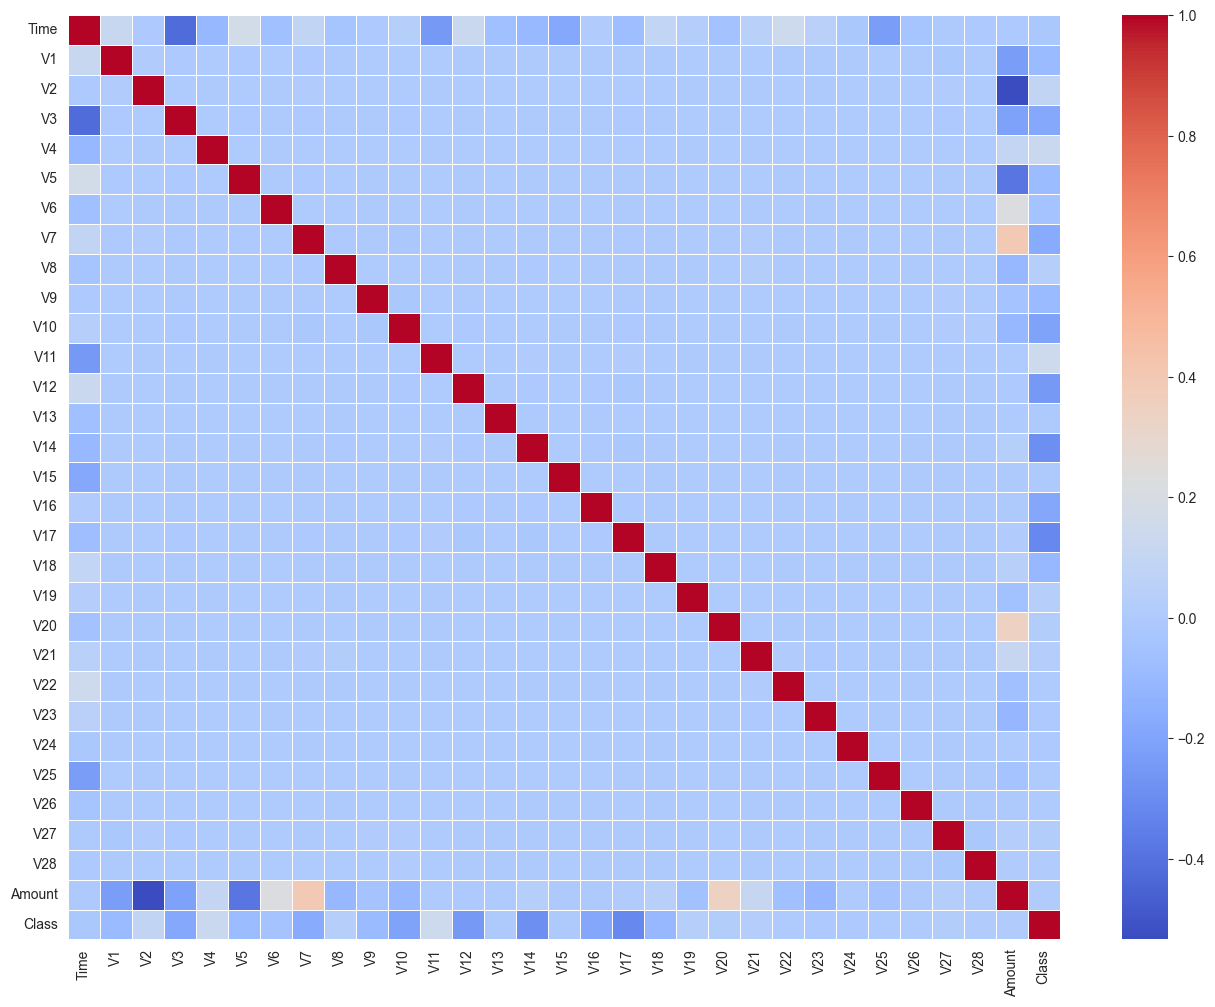

In [11]:
# Plot a Heatmap
correlation_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(16,12))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, linewidths=0.5)

# Correaltions in Descending order
cor_target = correlation_matrix['Class'].sort_values(ascending=False)
print(cor_target)

In [12]:
# Automatically find top N features most correlated with 'Class'
def get_top_corr_features(df, target='Class', top_n=10, exclude_target=True):
    corr_matrix = df.corr()
    target_corr = corr_matrix[target].abs().sort_values(ascending=False)
    
    if exclude_target:
        target_corr = target_corr.drop(target)
    
    return target_corr.head(top_n).index.tolist()

Top correlated features with 'Class': ['V17', 'V14', 'V12', 'V10', 'V16']


/var/folders/yk/c2zwgvs964348mnrbq434tbh0000gn/T/ipykernel_66422/115454563.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Class', y=feature, data=df, palette='coolwarm', cut=0)


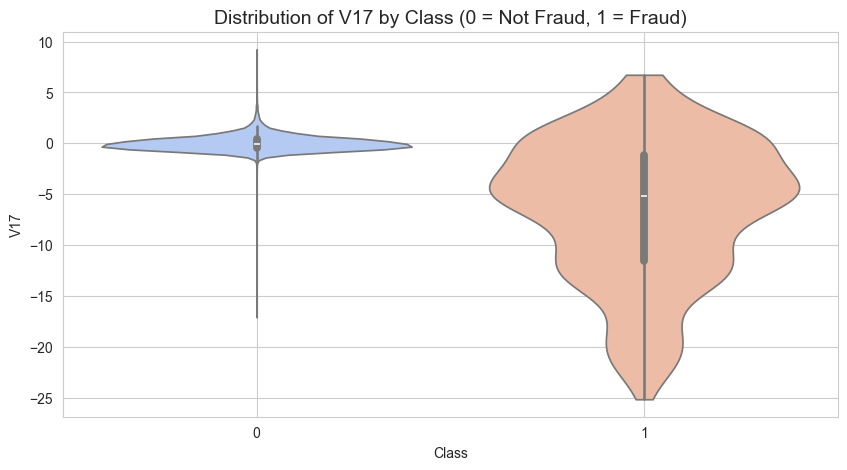

/var/folders/yk/c2zwgvs964348mnrbq434tbh0000gn/T/ipykernel_66422/115454563.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Class', y=feature, data=df, palette='coolwarm', cut=0)


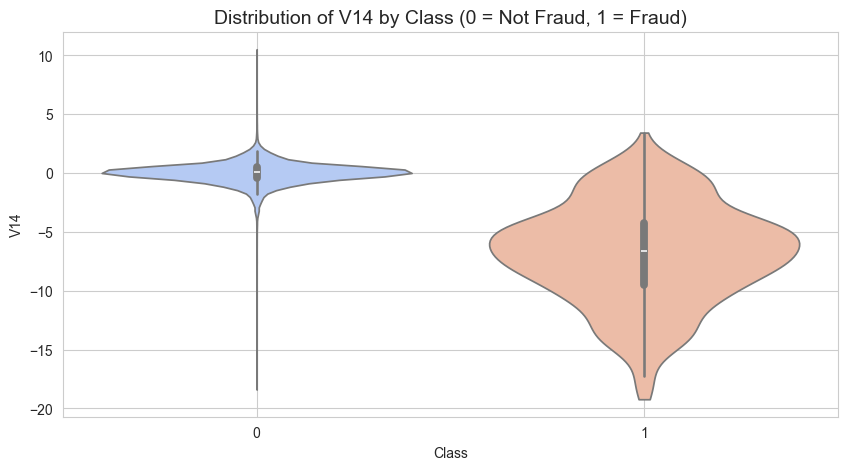

/var/folders/yk/c2zwgvs964348mnrbq434tbh0000gn/T/ipykernel_66422/115454563.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Class', y=feature, data=df, palette='coolwarm', cut=0)


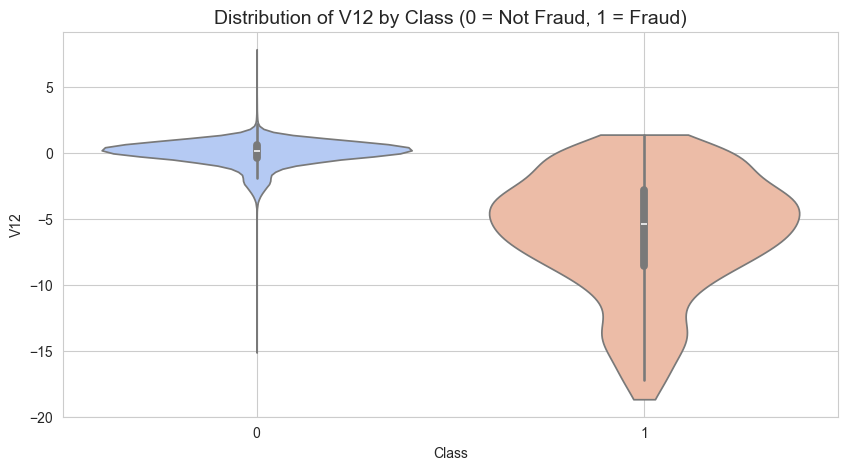

/var/folders/yk/c2zwgvs964348mnrbq434tbh0000gn/T/ipykernel_66422/115454563.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Class', y=feature, data=df, palette='coolwarm', cut=0)


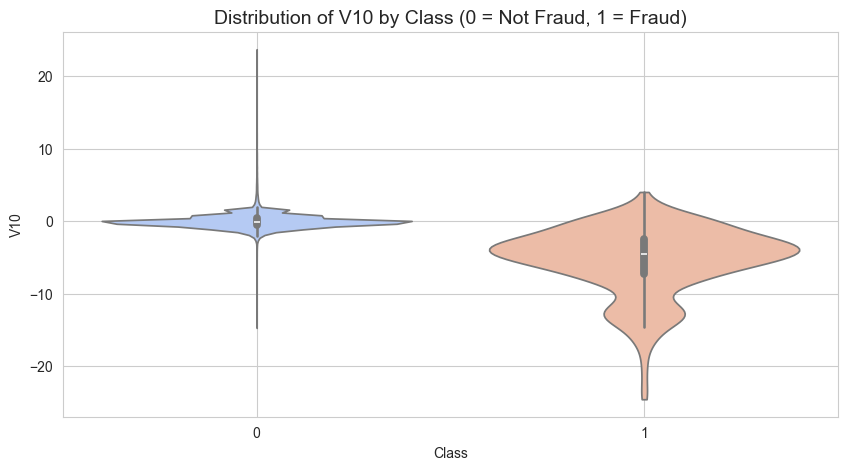

/var/folders/yk/c2zwgvs964348mnrbq434tbh0000gn/T/ipykernel_66422/115454563.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Class', y=feature, data=df, palette='coolwarm', cut=0)


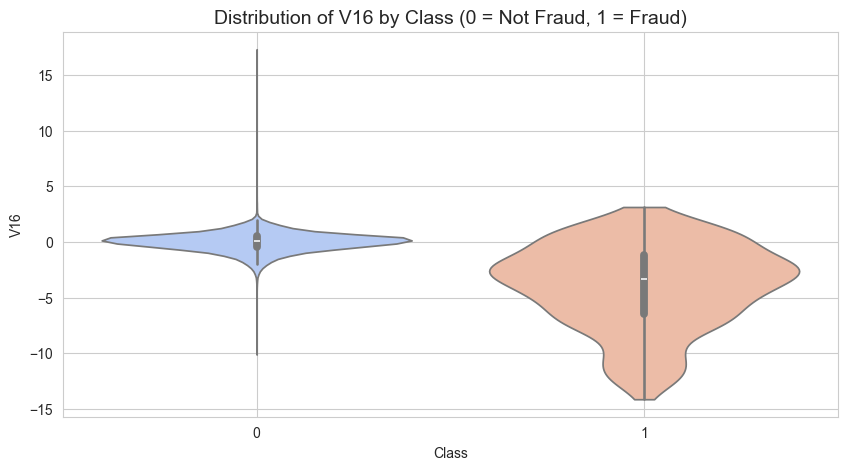

In [13]:
# Top Correlating Features with class
top_features = get_top_corr_features(df, top_n=5)

print("Top correlated features with 'Class':", top_features)

# Create Violinplots of top features
for feature in top_features:
    plt.figure(figsize=(10, 5))
    
    sns.violinplot(x='Class', y=feature, data=df, palette='coolwarm', cut=0)
    plt.title(f'Distribution of {feature} by Class (0 = Not Fraud, 1 = Fraud)', fontsize=14)
    plt.xlabel('Class')
    plt.ylabel(feature)
    plt.grid(True)
    plt.show()

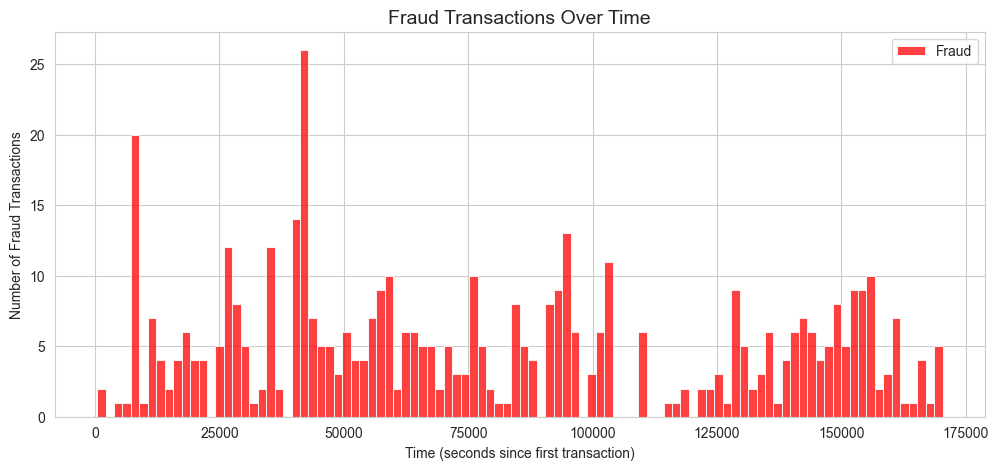

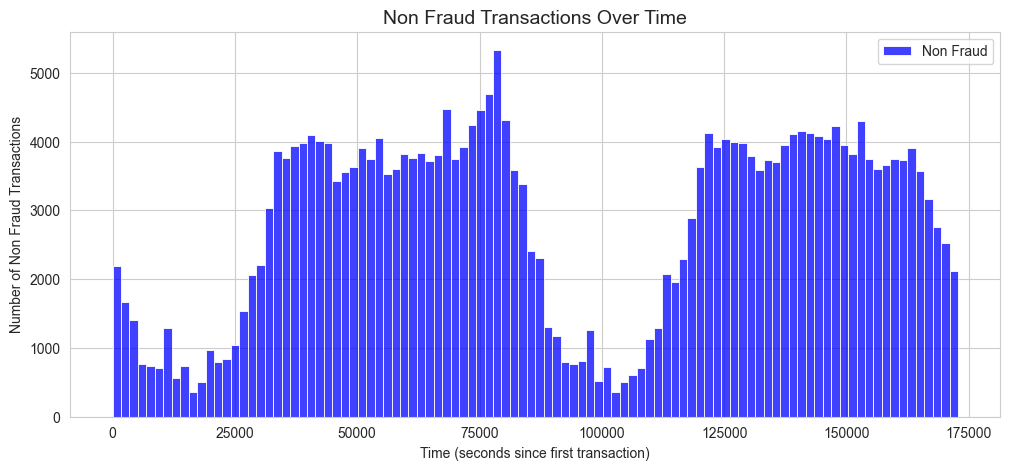

In [14]:
# Plot frauds over time
plt.figure(figsize=(12, 5))
sns.histplot(fraud['Time'], bins=100, color='red', label='Fraud', kde=False)
plt.title("Fraud Transactions Over Time", fontsize=14)
plt.xlabel("Time (seconds since first transaction)")
plt.ylabel("Number of Fraud Transactions")
plt.legend()
plt.grid(True)
plt.show()

# Plot Non frauds over time
plt.figure(figsize=(12, 5))
sns.histplot(non_fraud['Time'], bins=100, color='blue', label='Non Fraud', kde=False)
plt.title("Non Fraud Transactions Over Time", fontsize=14)
plt.xlabel("Time (seconds since first transaction)")
plt.ylabel("Number of Non Fraud Transactions")
plt.legend()
plt.grid(True)
plt.show()

## Fraud rate per hour

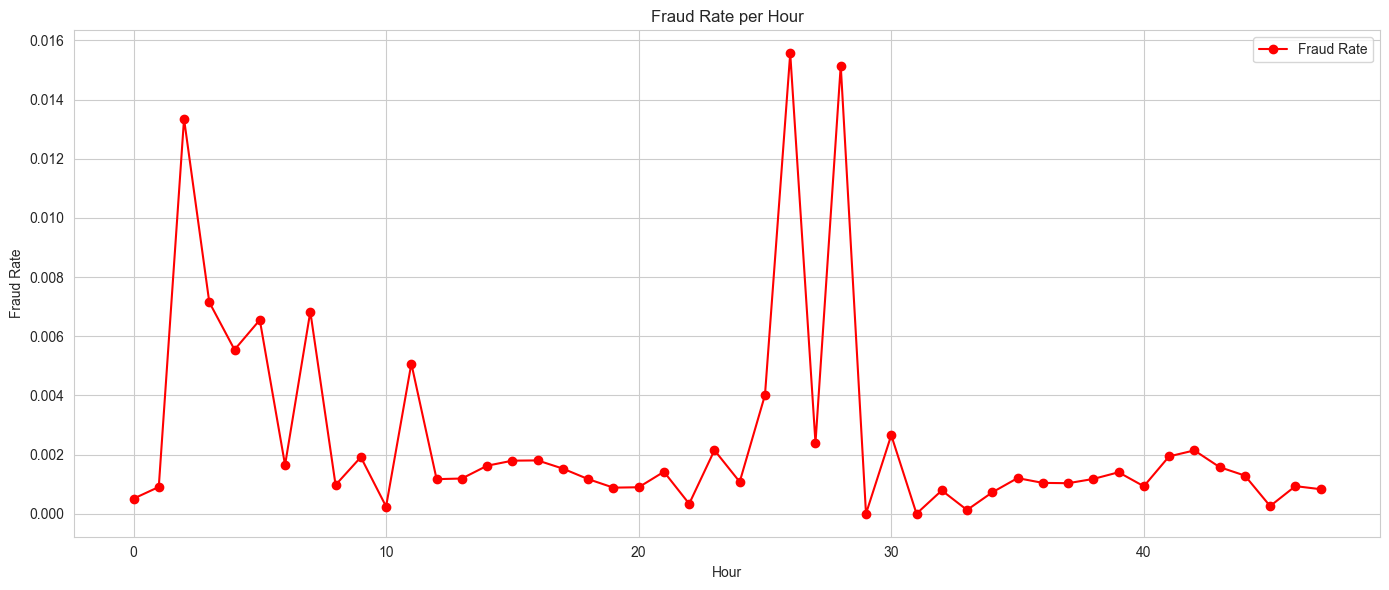

In [15]:
df['Hour'] = df['Time'] // 3600  # Each hour is 3600 seconds

# Calculate Fraud rate per hour
hourly_counts = df.groupby('Hour')['Class'].value_counts().unstack().fillna(0)
hourly_counts.columns = ['Non-Fraud', 'Fraud']
hourly_counts['Total'] = hourly_counts['Non-Fraud'] + hourly_counts['Fraud']
hourly_counts['Fraud_Rate'] = hourly_counts['Fraud'] / hourly_counts['Total']
# Update fraud and Non fraud
fraud = df[df['Class']==1]
non_fraud = df[df['Class']==0]

# Plot fraud rate over time
plt.figure(figsize=(14, 6))
plt.plot(hourly_counts.index, hourly_counts['Fraud_Rate'], marker='o', color='red', label='Fraud Rate')
plt.xlabel('Hour')
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate per Hour')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Transaction density by hour

In [16]:
non_fraud

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Hour
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,47.0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,47.0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,47.0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,47.0


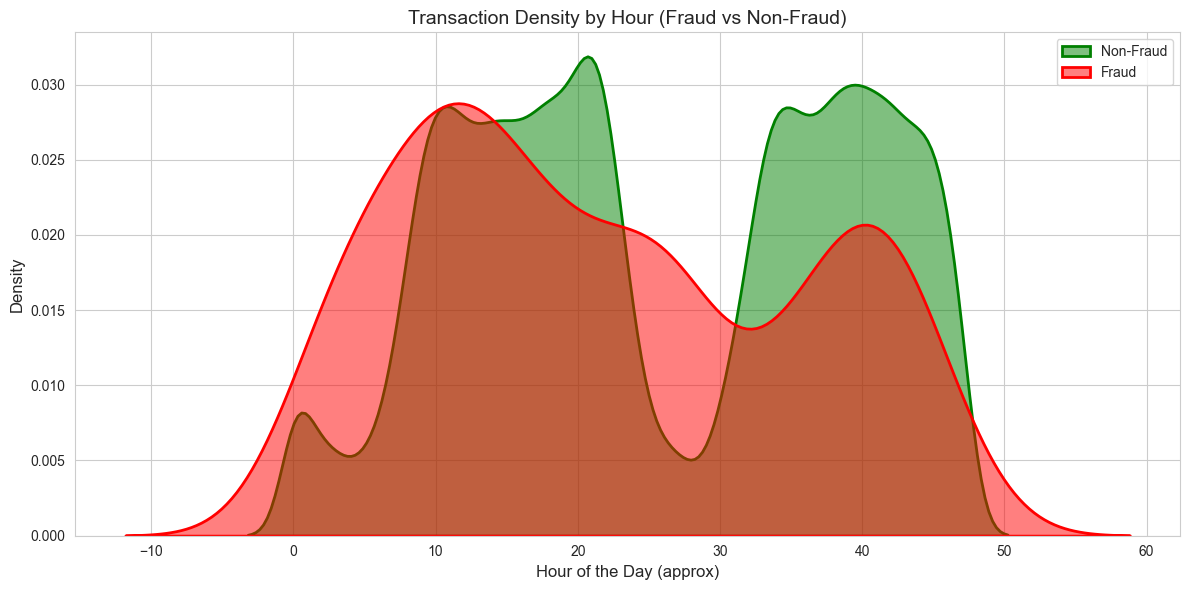

In [17]:
plt.figure(figsize=(12, 6))

# Plotting KDE for non-fraud (Class 0)
sns.kdeplot(non_fraud['Hour'], label='Non-Fraud', fill=True, color='green', alpha=0.5, linewidth=2)

# Plotting KDE for fraud (Class 1)
sns.kdeplot(fraud['Hour'], label='Fraud', fill=True, color='red', alpha=0.5, linewidth=2)

plt.title('Transaction Density by Hour (Fraud vs Non-Fraud)', fontsize=14)
plt.xlabel('Hour of the Day (approx)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Total Transactions & Fraud Rate per Hour

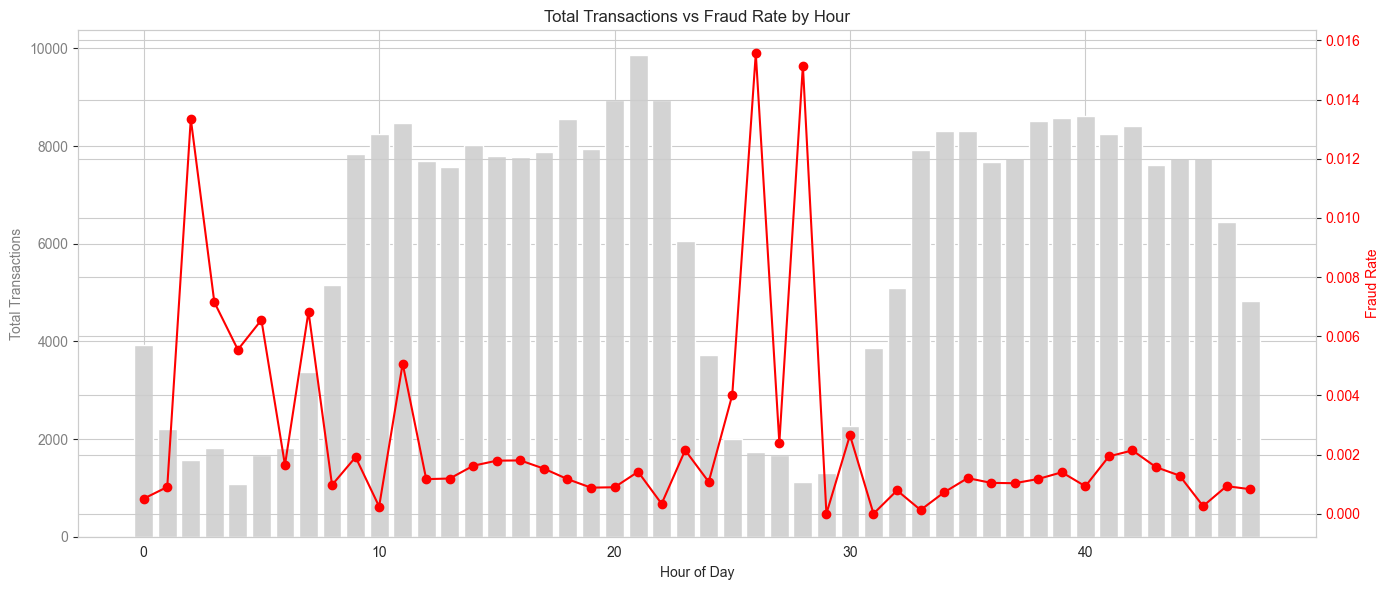

In [18]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# Bar plot for total transactions
ax1.bar(hourly_counts.index, hourly_counts['Total'], color='lightgray', label='Total Transactions')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Total Transactions', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

# Twin axis for fraud rate
ax2 = ax1.twinx()
ax2.plot(hourly_counts.index, hourly_counts['Fraud_Rate'], color='red', marker='o', label='Fraud Rate (%)')
ax2.set_ylabel('Fraud Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and grid
plt.title('Total Transactions vs Fraud Rate by Hour')
fig.tight_layout()
plt.grid(True)
plt.show()

## Transaction Magnitudes & Feature Variability


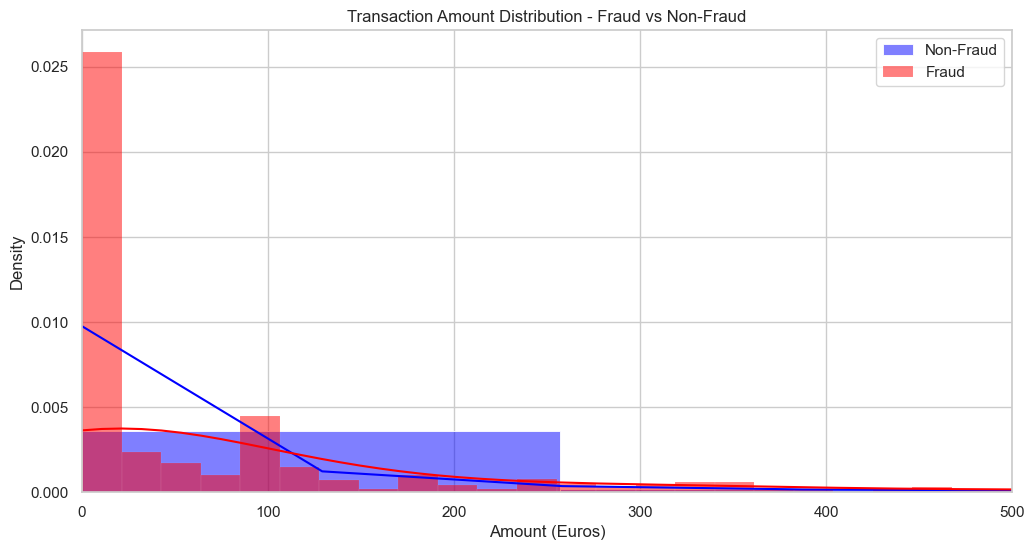

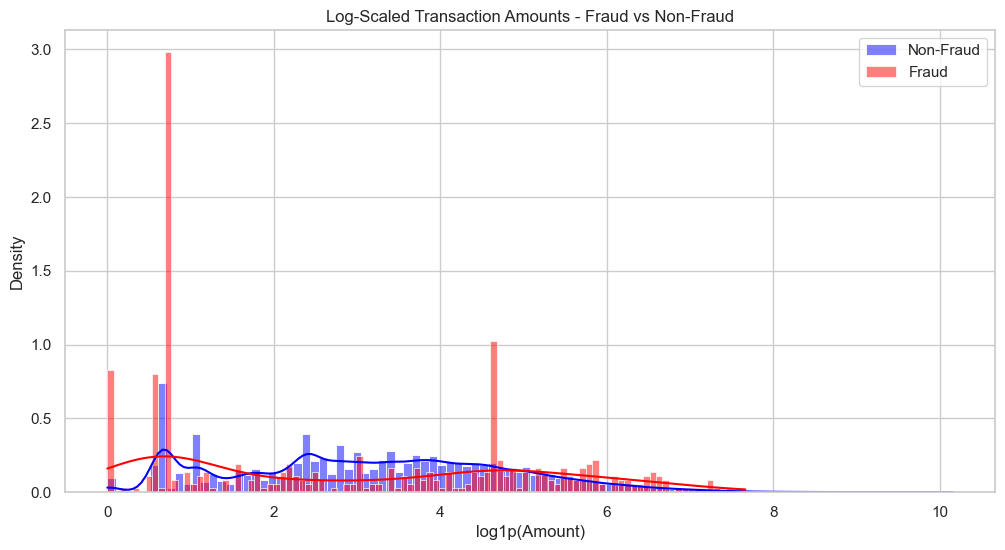

Non-Fraud Amount Stats:
 count    283253.000000
mean         88.413575
std         250.379023
min           0.000000
25%           5.670000
50%          22.000000
75%          77.460000
max       25691.160000
Name: Amount, dtype: float64 

Fraud Amount Stats:
 count     473.000000
mean      123.871860
std       260.211041
min         0.000000
25%         1.000000
50%         9.820000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


In [21]:
sns.set(style="whitegrid")

# Transaction amount distribution
plt.figure(figsize=(12, 6))
sns.histplot(non_fraud['Amount'], bins=100, color='blue', label='Non-Fraud', stat='density', kde=True)
sns.histplot(fraud['Amount'], bins=100, color='red', label='Fraud', stat='density', kde=True)
plt.legend()
plt.title('Transaction Amount Distribution - Fraud vs Non-Fraud')
plt.xlabel('Amount (Euros)')
plt.ylabel('Density')
plt.xlim([0, 500])  # Clamp for clarity
plt.show()

# Log-transformed Amounts
plt.figure(figsize=(12, 6))
sns.histplot(np.log1p(non_fraud['Amount']), bins=100, color='blue', label='Non-Fraud', stat='density', kde=True)
sns.histplot(np.log1p(fraud['Amount']), bins=100, color='red', label='Fraud', stat='density', kde=True)
plt.legend()
plt.title('Log-Scaled Transaction Amounts - Fraud vs Non-Fraud')
plt.xlabel('log1p(Amount)')
plt.ylabel('Density')
plt.show()

# Quick Summary Stats
print("Non-Fraud Amount Stats:\n", non_fraud['Amount'].describe(), "\n")
print("Fraud Amount Stats:\n", fraud['Amount'].describe())

## Feature Significance (ANOVA) & Distribution (KDE)

In [26]:
top_features 

['V17', 'V14', 'V12', 'V10', 'V16']

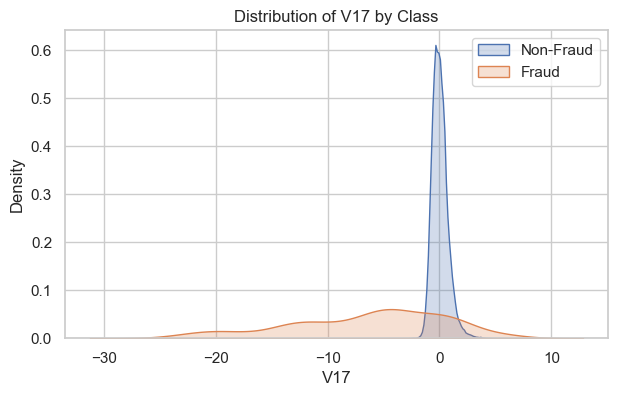

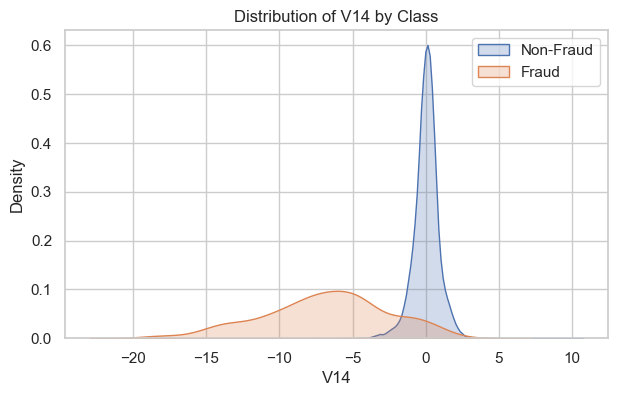

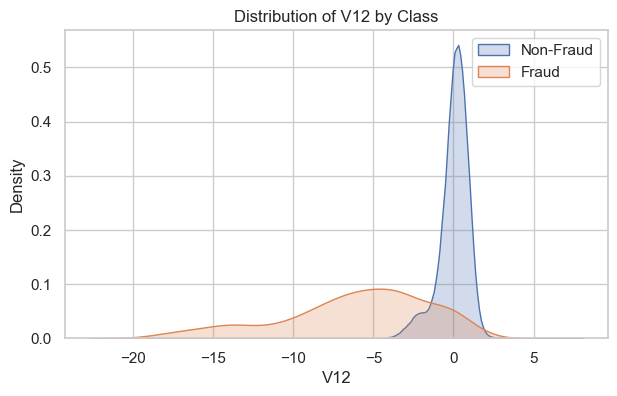

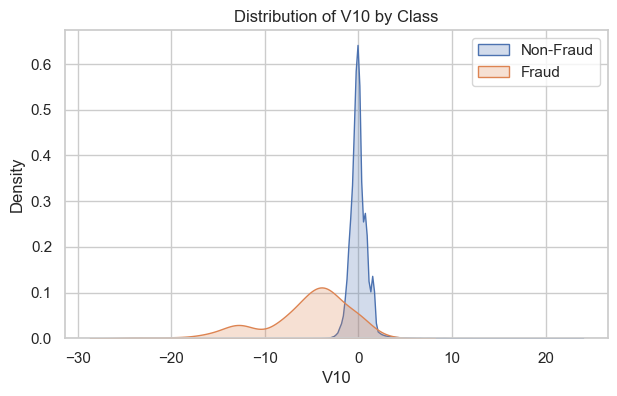

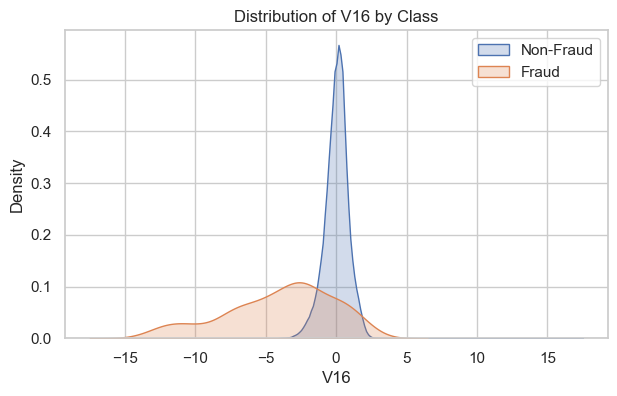

  Feature  F-Statistic  P-Value
0     V17   30923.9697      0.0
1     V14   26719.6069      0.0
2     V12   19029.9296      0.0
3     V10   12697.8505      0.0
4     V16   10302.2744      0.0


In [30]:
# Store results
anova_results = []

# Loop through features
for feat in top_features:
    fraud_values = df[df['Class'] == 1][feat]
    nonfraud_values = df[df['Class'] == 0][feat]
    
    # ANOVA test
    f_stat, p_val = f_oneway(fraud_values, nonfraud_values)
    
    # Append result
    anova_results.append({
        'Feature': feat,
        'F-Statistic': f_stat,
        'P-Value': p_val
    })
    
    # Plot
    plt.figure(figsize=(7, 4))
    sns.kdeplot(nonfraud_values, label='Non-Fraud', fill=True)
    sns.kdeplot(fraud_values, label='Fraud', fill=True)
    plt.title(f'Distribution of {feat} by Class')
    plt.legend()
    plt.show()

# Create and show ANOVA summary
anova_df = pd.DataFrame(anova_results)
print(anova_df.sort_values(by='F-Statistic', ascending=False).round(4))

## Multivariate Analysis & Feature Engineering

In [28]:
non_fraud_values = df[df['Class'] == 0]['V14']
non_fraud_values

0        -0.311169
1        -0.143772
2        -0.165946
3        -0.287924
4        -1.119670
            ...   
284802    4.626942
284803   -0.675143
284804   -0.510602
284805    0.449624
284806   -0.084316
Name: V14, Length: 283253, dtype: float64

In [29]:
f_stat, p_val = f_oneway(fraud_values, non_fraud_values)
f_stat, p_val 

(26719.606941719092, 0.0)